### Packages import


In [1]:
# import os
# import glob
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from torchvision import models, transforms
from sklearn.model_selection import train_test_split

from skimage import io
from PIL import Image

In [3]:
 
directory = ""
train_images = "augmented_dataset/train_images/*.png" # all images start by 0 # transformed will start by "transormation_name"
train_masks = "augmented_dataset/train_masks/*.png"

## Data Loading and Preprocessing

In [4]:
# Load image and mask file names, and make sure they are ordered the same
image_list = list(glob.glob(os.path.join(directory + train_images)))
mask_list = list(glob.glob(os.path.join(directory + train_masks)))
image_list = np.sort(image_list)
mask_list = np.sort(mask_list)


In [5]:
print(len(image_list), len(mask_list))
assert len(image_list) == len(mask_list), print(len(image_list), len(mask_list))
# print(image_list[3000:3010])
# print(mask_list[3000:3O1O])

5312 5312


In [6]:

# Split between train and validation
threshold = int(0.8*len(image_list))
train_images = image_list[:threshold]
train_masks = mask_list[:threshold]
validation_images = image_list[threshold:]
validation_masks = mask_list[threshold:]


# Normalization of images to put emphasis on contrast between green colors and the rest
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.71, 0.57, 0.74],
                         std=[0.10, 0.15, 0.10])
])
# https://pytorch.org/docs/stable/torchvision/transforms.html

In [7]:
# Definition of the DataSet class to feed to the dataloader
class CellDataset(Dataset):
    def __init__(self, img_list, msk_list):
        self.images = img_list
        self.masks = msk_list

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index])) / 255.0
        image = np.array(transform(image))
      
        mask = np.array(Image.open(self.masks[index]))
        mask = (mask > 1) * 1.
        
        return image, mask

    def __len__(self):
        return len(self.images)

In [8]:
# Instantiation
train_dataset = CellDataset(train_images, train_masks)
val_dataset = CellDataset(validation_images, validation_masks)

## Model

### Architecture

In [9]:
# Dictionary to allow adjustment of the activation functions across the layers
activation_dict = {
    "relu": nn.ReLU(inplace=True),
    "leaky_relu": nn.LeakyReLU(inplace=True),
    "sigmoid": nn.Sigmoid(),
    "softmax": nn.Softmax(1)
}

In [10]:
# Auxiliary class which performs a 3x3 kernel convolution followed by an activation, and batch norm if needed
class Conv(nn.Module):

    def __init__(self, in_channels, out_channels, activation="relu", bn=True):
        super(Conv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation_dict[activation]
        self.bn = bn

        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, 3, 1, 1)

        if self.bn:
            self.bn1 = nn.BatchNorm2d(out_channels)
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.activation(output)
        if self.bn:
            output = self.bn1(output)
        return output

In [11]:
# Revised UNet architecture, with a bit of a change in the number of channels
# Start filters determines the number of channels that is doubled across each layer of the UNet
class UNet(nn.Module):
    
    def __init__(self, start_filters=64):
        super(UNet, self).__init__()

        self.down1 = nn.Sequential(
            Conv(3, start_filters, activation="relu", bn=True),
            Conv(start_filters, start_filters, activation="relu", bn=True)
        )

        self.down2 = nn.Sequential(
            Conv(start_filters, 2*start_filters, activation="relu", bn=True),
            Conv(2*start_filters, 2*start_filters, activation="relu", bn=True)
        )
        
        self.down3 = nn.Sequential(
            Conv(2*start_filters, 4*start_filters, activation="relu", bn=True),
            Conv(4*start_filters, 4*start_filters, activation="relu", bn=True)
        )
        
        self.down4 = nn.Sequential(
            Conv(4*start_filters, 4*start_filters, activation="relu", bn=True),
            Conv(4*start_filters, 4*start_filters, activation="relu", bn=True)
        )

        self.up4 = nn.Sequential(
            Conv(4*start_filters, 8*start_filters, activation="relu", bn=True),
            Conv(8*start_filters, 4*start_filters, activation="relu", bn=True),
            nn.ConvTranspose2d(4*start_filters, 4*start_filters, 2, 2, dilation=1),
        )

        self.up3 = nn.Sequential(
            Conv(8*start_filters, 8*start_filters, activation="relu", bn=True),
            Conv(8*start_filters, 4*start_filters, activation="relu", bn=True),
            nn.ConvTranspose2d(4*start_filters, 4*start_filters, 2, 2, dilation=1),
        )

        self.up2 = nn.Sequential(
            Conv(8*start_filters, 4*start_filters, activation="relu", bn=True),
            Conv(4*start_filters, 2*start_filters, activation="relu", bn=True),
            nn.ConvTranspose2d(2*start_filters, 2*start_filters, 2, 2, dilation=1),
        )

        self.up1 = nn.Sequential(
            Conv(4*start_filters, 2*start_filters, activation="relu", bn=True),
            Conv(2*start_filters, start_filters, activation="relu", bn=True),
            nn.ConvTranspose2d(start_filters, start_filters, 2, 2, dilation=1),
        )

        self.final = nn.Sequential(
            Conv(2*start_filters, start_filters, activation="relu", bn=True),
            Conv(start_filters, start_filters, activation="relu", bn=True),
            nn.Conv2d(start_filters, 1, 1, 1),
        )

        self.drop_out = nn.Dropout(p= 0.1)


    def forward(self, inputs):
        left1 = self.down1(inputs)
        left2 = self.down2(F.max_pool2d(left1, kernel_size=2, stride=2))
        # left2 = self.drop_out(left2)
        left3 = self.down3(F.max_pool2d(left2, kernel_size=2, stride=2))
        # left3 = self.drop_out(left3)
        left4 = self.down4(F.max_pool2d(left3, kernel_size=2, stride=2))
        # left4 = self.drop_out(left4)
        right4 = torch.cat((left4, self.up4(F.max_pool2d(left4, kernel_size=2, stride=2))), 1)
        # right4 = self.drop_out(right4)
        right3 = torch.cat((left3, self.up3(right4)), 1)
        # right3 = self.drop_out(right3)
        right2 = torch.cat((left2, self.up2(right3)), 1)
        # right2 = self.drop_out(right2)
        right1 = torch.cat((left1, self.up1(right2)), 1)
        outputs = torch.sigmoid(self.final(right1))

        return outputs

### Loss Function

In [12]:
# Definitioin of the DiceLoss, which is the measure of error with regards to the Dice Score, that's used for model evaluation
class DiceLoss(nn.Module):
    
    def _init_(self):
        super(DiceLoss, self)._init_()
    
    def forward(self, X, Y):
        Y = Y.unsqueeze(1).type_as(X)
        smooth = 1e-8
        num = Y.size(0)
        X = X.view(num,-1)
        Y = Y.view(num,-1)
        intersection = (X * Y).sum(dim=1)
        union = X.sum(dim=1) + Y.sum(dim=1)
        dice = 2. * (intersection + smooth) / (union + smooth)
        dice = 1 - dice.sum() / num
        return dice

### Training function

In [ ]:
from tqdm import tqdm

def train(num_epochs, batch_size, criterion, optimizer, model,
          train_dataset=train_dataset, val_dataset=val_dataset,
          save_model=True, model_name='Untitled'):
  
    train_error, val_error = [], []

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
        
    for epoch in range(num_epochs):

        ### TRAINING
        model.train()
        epoch_avg_train_loss = 0.0
        for _, batch, in enumerate(tqdm(train_dataloader)):
            images, masks = batch
            outputs = model(images.cuda().float())
            loss = criterion(outputs, masks.cuda().float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_avg_train_loss += loss.item() * batch_size / len(train_dataset)

        ### VALIDATION
        model.eval()
        epoch_avg_val_loss = 0.0
        for _, batch, in enumerate(tqdm(val_dataloader)):
          val_images, val_masks = batch
          val_outputs = model(val_images.cuda().float())
          val_loss = criterion(val_outputs, val_masks.cuda().float())
          epoch_avg_val_loss += val_loss.item() * batch_size / len(val_dataset)

        scheduler.step(epoch_avg_train_loss)

        tac = time.time()

        print('Epoch [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}'
              .format(epoch+1, num_epochs, epoch_avg_train_loss, epoch_avg_val_loss))

        train_error.append(epoch_avg_train_loss)
        val_error.append(epoch_avg_val_loss)

        torch.cuda.empty_cache()
    
        if save_model:
            torch.save(model.state_dict(), '/content/drive/MyDrive/FDL/models/{}_{}.pt'.format(model_name, epoch + 1))
        
    return train_error, val_error

## Training

In [ ]:
model = UNet(64)
model.cuda()

num_epochs = 30
batch_size = 16

criterion = DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9) #, weight_decay=0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True, patience=2, cooldown=0)

In [ ]:
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, 
                               train_dataset=train_dataset, val_dataset=val_dataset,
                               save_model=True, model_name='UNet_Decay_16_30_modified_dataset')

100%|██████████| 67/67 [09:34<00:00,  8.57s/it]


Epoch [1/30], Train loss: 0.3582, Val loss: 0.3269


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [2/30], Train loss: 0.2854, Val loss: 0.2766


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [3/30], Train loss: 0.2580, Val loss: 0.2651


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [4/30], Train loss: 0.2467, Val loss: 0.2535


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [5/30], Train loss: 0.2411, Val loss: 0.2385


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [6/30], Train loss: 0.2325, Val loss: 0.2515


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [7/30], Train loss: 0.2338, Val loss: 0.2401


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [8/30], Train loss: 0.2260, Val loss: 0.2355


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [9/30], Train loss: 0.2258, Val loss: 0.2414


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [10/30], Train loss: 0.2191, Val loss: 0.2436


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [11/30], Train loss: 0.2156, Val loss: 0.2289


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [12/30], Train loss: 0.2134, Val loss: 0.2285


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [13/30], Train loss: 0.2115, Val loss: 0.2307


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [14/30], Train loss: 0.2066, Val loss: 0.2252


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [15/30], Train loss: 0.2079, Val loss: 0.2311


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [16/30], Train loss: 0.2101, Val loss: 0.2287


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch [17/30], Train loss: 0.2014, Val loss: 0.2274


 98%|█████████▊| 260/266 [03:29<00:04,  1.24it/s]

In [ ]:
### batch size 16, lr 0.1
# Epoch [14/15], Train loss: 0.2089, Val loss: 0.2198

### batch size 8
# Epoch [13/30], Train loss: 0.2130, Val loss: 0.2216


### batchsize 16 # 0.81050
### dropout
# Epoch [26/30], Train loss: 0.1829, Val loss: 0.2142


In [ ]:
torch.save(model.state_dict(), 'models/UNET_64.pt')

### CUDA memory cleaning

### Visualization

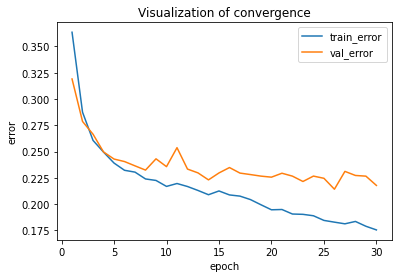

In [ ]:
plt.plot(range(1, num_epochs+1), train_error[0:], label='train_error')
plt.plot(range(1, num_epochs+1), val_error[0:], label='val_error')
plt.title("Visualization of convergence")
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()
plt.show()

In [ ]:
np.min(val_error), np.argmin(val_error)

(0.21420889627451284, 25)

## Submission

### Functions

In [17]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [20]:
def submit(model, model_name):
    """Used for Kaggle submission: predicts and encode all test images"""
    
    model.load_state_dict(torch.load('models/{}.pt'.format(model_name)))
    model.cuda()
    model.eval()

    dir = '/content/drive/MyDrive/FDL/test_images/'
    N = len(list(os.listdir(dir)))

    csv_path = 'submissions/tresh_08_{}.csv'.format(model_name)
    with open(csv_path, 'w') as f:
        f.write('img,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            if index % 200 == 0:
                print('{}/{}'.format(index, N))

            img = np.array(Image.open(dir + i)) / 255.0
            img = transform(img).reshape(1,3,256,256)

            mask = (model(img.cuda().float()).cpu().detach().numpy()[0] > 0.7) * 1.
            enc = rle_encode(mask)
            f.write('{},{}\n'.format(i, enc))

### Model choice and submission

In [21]:
model = UNet(64)
model_name = 'UNet_Decay_16_30_modified_dataset_26' #Best submission for now

submit(model, model_name)

0/5245
200/5245
400/5245
600/5245
800/5245
1000/5245
1200/5245
1400/5245
1600/5245
1800/5245
2000/5245
2200/5245
2400/5245
2600/5245
2800/5245
3000/5245
3200/5245
3400/5245
3600/5245
3800/5245
4000/5245
4200/5245
4400/5245
4600/5245
4800/5245
5000/5245
5200/5245
